# Contents

In this Notebook I will Learn the RNN and its varient.
* Simple RNN's
* Word Embeddings : Definition and How to get them
* LSTM's
* GRU's
* BI-Directional RNN's
* Encoder-Decoder Models (Seq2Seq Models)
* Attention Models
* Transformers - Attention is all you need
* BERT
# Basic Help When Needed
- To Represent the world cloud and LDA use the below link
* https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

## Basic Information Regarding Sequence Model
- models that regress the value of a signal on the previous values of that same signal are naturally called autoregressive models
- First of all, we might believe that although long sequences $\boldsymbol{x}_{t-1},\ldots,\boldsymbol{x}_1$ are available, it may not be necessary to look back so far in the history when predicting the near future. In this case we might content ourselves to condition on some window of length $\tau$ and only use $\boldsymbol{x}_{t-1},\ldots,\boldsymbol{x}_{t-\tau}$ observations. The immediate benefit is that now the number of arguments is always the same, at least for $t > \tau$. This allows us to train any linear model or deep network that requires fixed-length vectors as inputs.

- Second, we might develop models that maintain some summary $\boldsymbol{h}_t$ of the past observations (see Fig. 9.1.2) and at the same time update $\boldsymbol{h}_t$ in addition to the prediction $\hat{\boldsymbol{x}}^t$. This leads to models that estimate not only $\boldsymbol{x}_t$ with $\hat{\boldsymbol{x}}_t = P(\boldsymbol{x}_t|\boldsymbol{h}_t)$ but also updates of the form $\boldsymbol{h}_t = g(\boldsymbol{h}_{t-1}, \boldsymbol{x}_{t-1})$. Since $\boldsymbol{h}_t$ is never observed, these models are also called latent autoregressive models.
## Language Model
- when working with language, we wish to estimate the joint probability of an entire sequence. This is a common task when working with sequences composed of discrete tokens, such as words. Generally, these estimated functions are called sequence models and for natural language data, they are called language models.
- Language modeling as autoregression: P(x_1, ..., x_T) decomposed using chain rule into P(x_1) * P(x_2 | x_1) * ... * P(x_T | x_(T-1), ..., x_1). Autoregressive prediction: predict x_t based on x_(t-1), ..., x_1.
- Now suppose that we wish to employ the strategy mentioned above, where we condition only on the "a" previous time steps rather then entire sequence history "t" when we does this it satifies a Markov condition, i.e., that the future is conditionally independent of the past, given the recent history. when a=1 then 1st order Markov model. 
- We often find it useful to work with models that proceed as though a Markov condition were satisfied, even when we know that this is only approximately true. 
- Sometimes we compromise, obviating computational and statistical difficulties by training models whose validity depends on a Kth -order Markov condition. Even today’s massive RNN- and Transformer-based language models seldom incorporate more than thousands of words of context.
-  why we represented the factorization of a text sequence  as a left-to-right chain of conditional probabilities. ans(represent sequence as we read as it better for other lang like arabic that right to left)

In [5]:
# libraries
import collections # libraries for different DS
import random # to generate random numbers
import re # regular expression using in preprocessing
import torch # pytorch library
import pandas as pd # pandas to read and manipulate the 
import nltk # text processing library
from nltk.corpus import stopwords # stop words library
from sklearn.feature_extraction.text import CountVectorizer # used for finding vaccub
import gensim # pretrained model by google for converting word to vector
from gensim.models import Word2Vec # word 2 vector 
import numpy as np # processing effeciently vectors
from gensim.test.utils import datapath # load the datapath 
import torch.nn as nn # neural network  base class
from torch.utils.data import DataLoader, Dataset # construct dataset to store in the 
from sklearn.model_selection import train_test_split # Define dataset and dataloader for efficient
import torch.optim as optim ## for smapling different paramter to findd the optimal parameter for any neural network
import math # math operations
from torch.nn import functional as F # (forwords functions)

## Converting Raw Text into Sequence Data

In [3]:
text='the time machine by h g wells i the time traveller for so it'
tokens=list(text)
class Vocab:  #@save
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [16, 8, 5, 0, 16, 9, 11, 5, 0, 11]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [4]:
print("unigram model")
words = text.split()
vocab = Vocab(words)
print(vocab.token_freqs[:10])
print("Bigram model")
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
print(bigram_vocab.token_freqs[:10])

unigram model
[('the', 2), ('time', 2), ('machine', 1), ('by', 1), ('h', 1), ('g', 1), ('wells', 1), ('i', 1), ('traveller', 1), ('for', 1)]
Bigram model
[('the--time', 2), ('time--machine', 1), ('machine--by', 1), ('by--h', 1), ('h--g', 1), ('g--wells', 1), ('wells--i', 1), ('i--the', 1), ('time--traveller', 1), ('traveller--for', 1)]


## RNN
What is a RNN?

Recurrent Neural Network(RNN) are a type of Neural Network where the output from previous step are fed as input to the current step. In traditional neural networks, all the inputs and outputs are independent of each other, but in cases like when it is required to predict the next word of a sentence, the previous words are required and hence there is a need to remember the previous words. Thus RNN came into existence, which solved this issue with the help of a Hidden Layer.

Why RNN's?
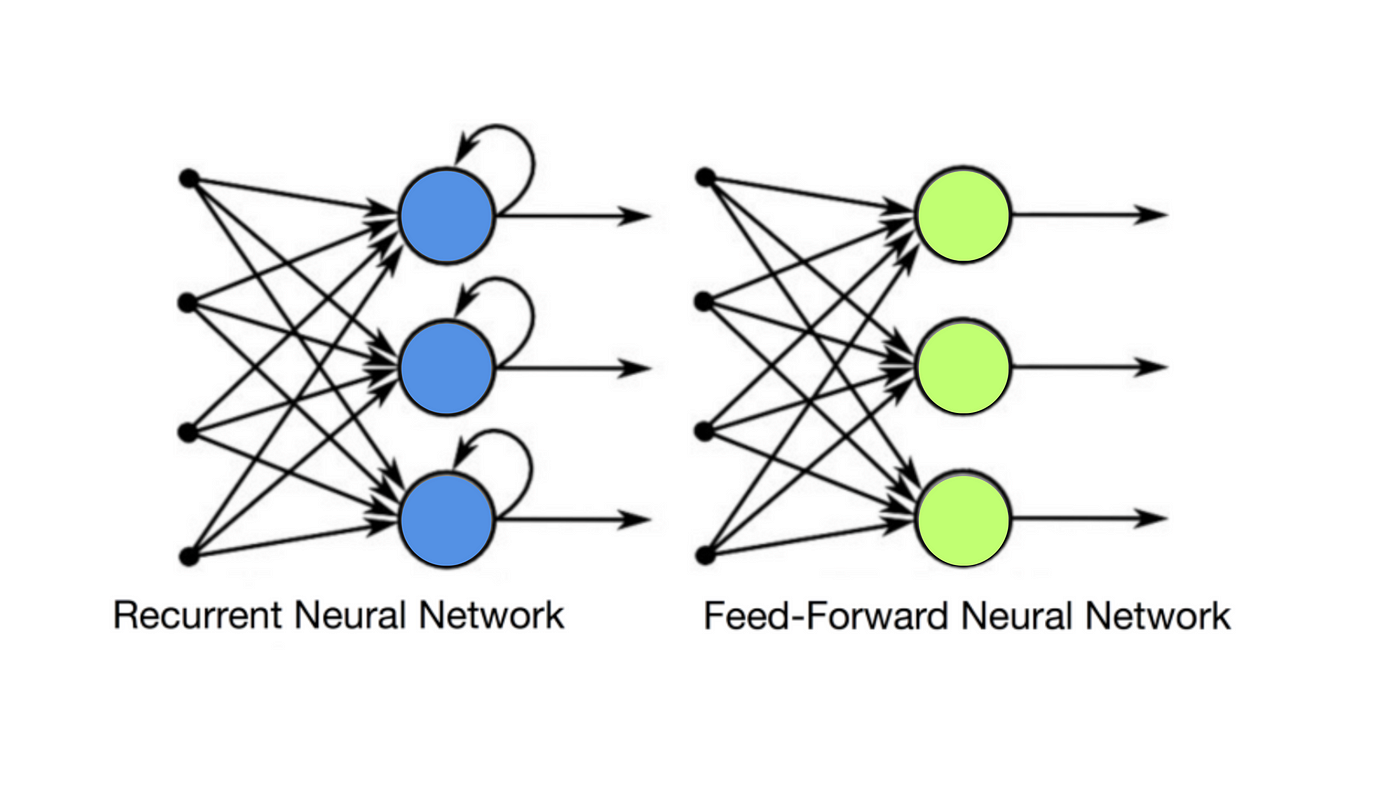


### MLP with single layer
when we look to MLP with a single hidden layer. Let the hidden layer's activation function be $\phi$. Given a minibatch of examples $\mathbf{X} \in \mathbb{R}^{n \times d}$ with batch size $n$ and $d$ inputs, the hidden layer output $\mathbf{H} \in \mathbb{R}^{n \times h}$ is calculated as
\begin{equation}
\mathbf{H} = \phi(\mathbf{X}\mathbf{W}_{xh} + \mathbf{b}_h).
\end{equation}
Here , we have the weight parameter $\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$, the bias parameter $\mathbf{b}_h \in \mathbb{R}^{1 \times h}$, and the number of hidden units $h$ for the hidden layer. So armed, we apply broadcasting (passing input to all the nodes) during the summation. Next, the hidden layer output $\mathbf{H}$ is used as input of the output layer, which is given by
\begin{equation}
\mathbf{O} = \mathbf{H}\mathbf{W}_{hq} + \mathbf{b}_q,
\end{equation}
where $\mathbf{O} \in \mathbb{R}^{n \times q}$ is the output variable, $\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$ is the weight parameter, and $\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ is the bias parameter of the output layer. If it is a classification problem, we can use softmax to compute the probability distribution of the output categories.

This is entirely analogous to the regression problem so we can pick feature-label pairs at random and learn the parameters of our network via automatic differentiation and stochastic gradient descent.

However, this feedforward networks struggle with sequential data like text or time series, where the order and relationships between elements are important

### Recurrent Neural Networks with Hidden States
RNNs address this limitation by incorporating a concept called memory. This allows them to consider not only the current input but also the context of previous inputs.

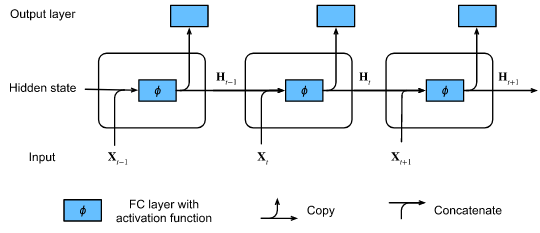

\begin{align*}
h_t &= f(W_{hh} \cdot h_{t-1} + W_x \cdot x_t + b) \\
o_t &= g(W_o \cdot h_t + b_o)
\end{align*}

Where ,
- h_t: Hidden state vector at time step t.
- f: Activation function (e.g., sigmoid, tanh).
- W_{hh}: Weight matrix connecting the hidden layer to itself.
- h_{t-1}: Hidden state vector at the previous time step (t-1).
- W_x: Weight matrix connecting the input layer to the hidden layer.
- x_t: Input vector at time step t.
- b: Bias vector for the hidden layer.
- o_t: Output vector at time step t.
- g: Activation function for the output layer (e.g., sigmoid, softmax).
- W_o: Weight matrix connecting the hidden layer to the output layer.
- b_o: Bias vector for the output layer.

- Recurrent Connection:

    - The key aspect of RNNs is the recurrent connection. The hidden state (h_t) is not just fed forward to the output layer; it's also fed back as input to the network at the next time step. This allows the network to carry information across time steps, making it suitable for processing sequential data.
    
- In Most of the RNN implimentation uses the concept called Tokenization
    -  It takes all the unique words in the corpus,forms a dictionary with words as keys and their number of occurences as values,it then sorts the dictionary in descending order of counts. It then assigns the first value 1 , second value 2 and so on. So let's suppose word 'the' occured the most in the corpus then it will assigned index 1 and vector representing 'the' would be a one-hot vector with value 1 at position 1 and rest zereos.
- A character-level language model based on the RNN
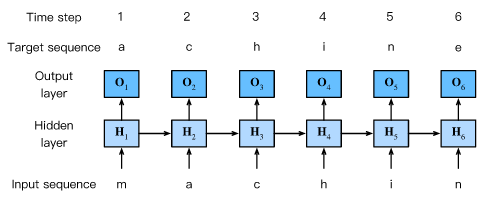

### LSTM
- Simple RNN's were certainly better than classical ML algorithms and gave state of the art results, but it failed to capture long term dependencies that is present in sentences . So in 1998-99 LSTM's were introduced to counter to these drawbacks.

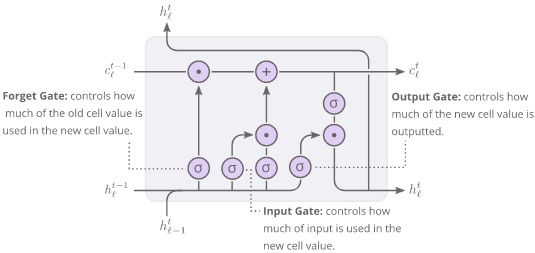

### GRU
Introduced by Cho, et al. in 2014, GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU's are a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results . GRU's were designed to be simpler and faster than LSTM's and in most cases produce equally good results and thus there is no clear winner.
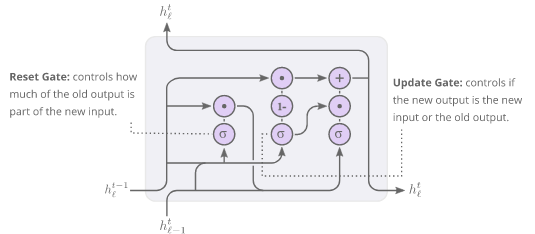


### BOTH 
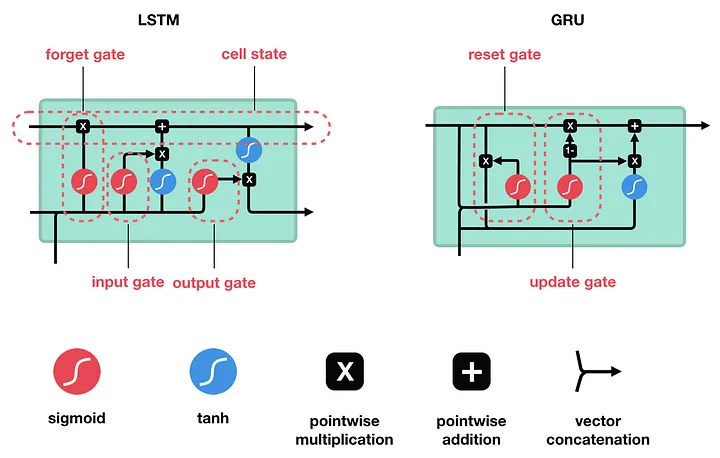


### BI-DIRECTIONAL RNN

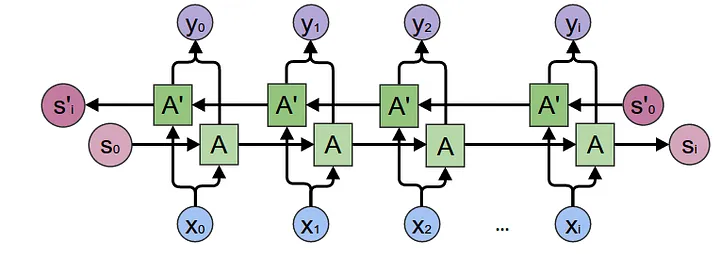
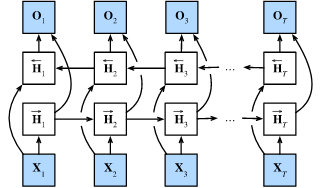

In [6]:
## RNN (basic Structure) Implimentation
class RNNScratch(torch.nn.Module):
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma = sigma
    
        # Initialize weights and biases using torch.nn.Parameter
        self.W_xh = torch.nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = torch.nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = torch.nn.Parameter(torch.zeros(num_hiddens))

    def forward(self, inputs, state=None):
        if state is None:
            # Initial state with shape: (batch_size, num_hiddens)
            state = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        else:
            state, = state  # Unpack the state 

        outputs = []
        for X in inputs:  # Loop through each input vector in the sequence
            state = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [7]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

## RNN for News Article Classification
- Since this is an classification task we can accumulate all the sequence information using avg output.

In [8]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the train and test datasets
train_df = pd.read_csv('/kaggle/input/nlp-ass-3/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-ass-3/test.csv')

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\\+', ' ', text)  # Replace '\\\\' with space
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    tokens = text.split()  # Split text into tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    
    text = ' '.join(tokens)  # Remove stopwords
    return text

# Apply preprocessing to train and test data
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# Display the preprocessed data
print(train_df['text'].head())
print(test_df['text'].head())
# Display the preprocessed data
# print(train_df['label'].nunique())
# print(test_df['label'].nunique())


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0    zimbabwe annual inflation drops percent report...
1    dead haiti mass grave haiti holds bodies may m...
2    seven die japan suicide pact japanese police f...
3    security afghan head president hamid karzai pr...
4    palestinians say hope bush accepts dealing ara...
Name: text, dtype: object
0    detainees seen minimal threat washington alleg...
1    japans army works plan cope north korean terro...
2    un council arrives nairobi un security council...
3    apec ministers urge new effort trade talks pac...
4    least five dead russia mine blast reuters reut...
Name: text, dtype: object


In [9]:
print("Sample of preprocessed data:")
print(train_df['text'].sample(10))
train_df['label'].value_counts()
# dataset is balanced

Sample of preprocessed data:
736     wenger fined wicked tongue appeal arsenal mana...
1535    bio datacruncher hits jackpot harvard biologis...
1021    uk ad firm wpp wins bid us rival reuters reute...
490     new voters sign battleground states ap ap look...
823     hornets snap game losing streak top warriors h...
1017    fortune names ebay ceo powerful woman business...
579     russia beat france win first fed cup russia ed...
679     brodeur hopes play despite sore wrist ap ap go...
1638    beagle money succeed summary nov new report uk...
208     tanks close sacred shrine us launches fresh as...
Name: text, dtype: object


label
0    500
1    500
2    500
3    500
Name: count, dtype: int64

In [10]:
# Create a CountVectorizer to create the vocabulary
vectorizer = CountVectorizer(min_df=5, max_df=0.95) 

# Fit the vectorizer on the train data
vectorizer.fit(train_df['text'])

# Vocabulary
vocabulary = vectorizer.get_feature_names_out()

# Display some vocabulary words
print("Vocabulary size:", len(vocabulary))
print("Sample vocabulary:", vocabulary[:20])

# Load pre-trained Word2Vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(datapath('word2vec_pre_kv_c'), binary=False)

# Function to get word embeddings for a sentence
def get_sentence_embedding(sentence, word2vec_model):
    tokens = sentence.split()
    embeddings = [word2vec_model[word] for word in tokens if word in word2vec_model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Generate embeddings for train and test data
# Generate embeddings for train and test data
train_embeddings = [get_sentence_embedding(sentence, word2vec_model) for sentence in train_df['text']]
test_embeddings = [get_sentence_embedding(sentence, word2vec_model) for sentence in test_df['text']]


Vocabulary size: 1975
Sample vocabulary: ['abbas' 'ability' 'able' 'access' 'according' 'accounting' 'accused'
 'acquisition' 'across' 'act' 'action' 'ad' 'add' 'added' 'adding'
 'administration' 'admitted' 'adopted' 'adrian' 'advance']


In [11]:
# Tokenization and Padding/Truncating
max_seq_length = 45

def tokenize_and_pad(text, word2vec_model, max_seq_length):
    tokens = text.split()[:max_seq_length]  # Truncate to max_seq_length
    token_ids = [word2vec_model.key_to_index[word] for word in tokens if word in word2vec_model.key_to_index]
    padded_token_ids = token_ids + [0] * (max_seq_length - len(token_ids))  # Pad with zeros
    return torch.tensor(padded_token_ids, dtype=torch.long)  # Convert to torch.LongTensor


# Apply the updated function to preprocess the text and generate token IDs
train_df['token_ids'] = train_df['text'].apply(lambda x: tokenize_and_pad(x, word2vec_model, max_seq_length))
test_df['token_ids'] = test_df['text'].apply(lambda x: tokenize_and_pad(x, word2vec_model, max_seq_length))


# Convert token_ids to PyTorch tensors
train_data = [(torch.tensor(token_ids, dtype=torch.long), label) for token_ids, label in zip(train_df['token_ids'], train_df['label'])]
test_data = [(torch.tensor(token_ids, dtype=torch.long), 0) for token_ids in test_df['token_ids']]  # Dummy labels for test data

# Define dataset and dataloader
class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

batch_size = 32
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

train_dataloader = DataLoader(TextDataset(train_data), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(TextDataset(val_data), batch_size=batch_size)
test_dataloader = DataLoader(TextDataset(test_data), batch_size=batch_size)

/tmp/ipykernel_34/3063201350.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = [(torch.tensor(token_ids, dtype=torch.long), label) for token_ids, label in zip(train_df['token_ids'], train_df['label'])]
/tmp/ipykernel_34/3063201350.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = [(torch.tensor(token_ids, dtype=torch.long), 0) for token_ids in test_df['token_ids']]  # Dummy labels for test data


In [12]:
# Define the RNN model with Vanilla RNN
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedding_weights, bidirectional=True):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=True)
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=bidirectional)    
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)
        # Second RNN layer
#         rnn_out2, _ = self.rnn2(rnn_out)
        avg_out = torch.mean(rnn_out, dim=1)
        out = self.dropout(avg_out)
        out = self.fc(out)
        return out
# Define the RNN model with LSTM (single layer of lstm) (for classification task)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedding_weights, bidirectional=True):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=True)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)
        self.dropout = nn.Dropout(0.12)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        avg_out = torch.mean(lstm_out, dim=1)
        out = self.dropout(avg_out)
        out = self.fc(out)
        return out

# Initialize the embedding layer with Word2Vec embeddings
embedding_weights = torch.FloatTensor(word2vec_model.vectors)
input_size = embedding_weights.size(1)  # Size of each embedding vector
output_size = 4  # Binary classification
hidden_size = 128  # Hidden size for RNN/LSTM
print("Embeddings o/p:",input_size,"No of Class:",output_size,"Hidden Size:",hidden_size)
# Instantiate the models
print(embedding_weights[0])
vanilla_rnn_model = VanillaRNN(input_size, hidden_size, output_size, embedding_weights)
lstm_model = LSTMModel(input_size, hidden_size, output_size, embedding_weights)
# Move models to device (CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vanilla_rnn_model.to(device)
lstm_model.to(device)

# Print model architectures
print("Vanilla RNN Model:\n", vanilla_rnn_model)
print("\nLSTM Model:\n", lstm_model)

Embeddings o/p: 10 No of Class: 4 Hidden Size: 128
Vanilla RNN Model:
 VanillaRNN(
  (embedding): Embedding(1750, 10)
  (rnn): RNN(10, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

LSTM Model:
 LSTMModel(
  (embedding): Embedding(1750, 10)
  (lstm): LSTM(10, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.12, inplace=False)
)


In [13]:
# For evaluation
from sklearn.metrics import accuracy_score, f1_score
# Training function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, accuracy, f1

In [14]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Adjust the learning rate (These Learning Rate found using the optium)
vanilla_rnn_optimizer = optim.Adam(vanilla_rnn_model.parameters(), lr=0.00017)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.0016)
# out(0.2)
# Training and validation
best_val_loss = float('inf')
best_model_state = None
num_epochs = 20

for epoch in range(num_epochs):
    train_loss = train(vanilla_rnn_model, train_dataloader, vanilla_rnn_optimizer, criterion, device)
    val_loss, val_accuracy, val_f1 = evaluate(vanilla_rnn_model, val_dataloader, criterion, device)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Vanilla RNN - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = vanilla_rnn_model.state_dict()

# Load the best model state
vanilla_rnn_model.load_state_dict(best_model_state)

# Evaluate on test set
test_loss, test_accuracy, test_f1 = evaluate(vanilla_rnn_model, test_dataloader, criterion, device)
print(f'\nVanilla RNN - Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}, Test F1: {test_f1:.4f}')

# Similarly, train and evaluate the LSTM model
best_val_loss = float('inf')
best_model_state = None
for epoch in range(num_epochs):
    train_loss = train(lstm_model, train_dataloader, lstm_optimizer, criterion, device)
    val_loss, val_accuracy, val_f1 = evaluate(lstm_model, val_dataloader, criterion, device)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, LSTM - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = lstm_model.state_dict()

# Load the best model state
lstm_model.load_state_dict(best_model_state)

# Evaluate on test set
test_loss, test_accuracy, test_f1 = evaluate(lstm_model, test_dataloader, criterion, device)
print(f'\nLSTM - Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}, Test F1: {test_f1:.4f}')


Epoch 1/20, Vanilla RNN - Train Loss: 1.3915, Val Loss: 1.3882, Val Acc: 0.2300, Val F1: 0.0935
Epoch 2/20, Vanilla RNN - Train Loss: 1.3903, Val Loss: 1.3830, Val Acc: 0.2450, Val F1: 0.1312
Epoch 3/20, Vanilla RNN - Train Loss: 1.3879, Val Loss: 1.3802, Val Acc: 0.3200, Val F1: 0.2007
Epoch 4/20, Vanilla RNN - Train Loss: 1.3820, Val Loss: 1.3752, Val Acc: 0.3400, Val F1: 0.2483
Epoch 5/20, Vanilla RNN - Train Loss: 1.3662, Val Loss: 1.3565, Val Acc: 0.3850, Val F1: 0.3672
Epoch 6/20, Vanilla RNN - Train Loss: 1.3583, Val Loss: 1.3487, Val Acc: 0.3700, Val F1: 0.3124
Epoch 7/20, Vanilla RNN - Train Loss: 1.3617, Val Loss: 1.3576, Val Acc: 0.3250, Val F1: 0.2567
Epoch 8/20, Vanilla RNN - Train Loss: 1.3632, Val Loss: 1.3529, Val Acc: 0.3450, Val F1: 0.3415
Epoch 9/20, Vanilla RNN - Train Loss: 1.3580, Val Loss: 1.3598, Val Acc: 0.3300, Val F1: 0.2469
Epoch 10/20, Vanilla RNN - Train Loss: 1.3491, Val Loss: 1.3484, Val Acc: 0.3350, Val F1: 0.3094
Epoch 11/20, Vanilla RNN - Train Loss: 

In [25]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
def test_evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return accuracy, f1
)
# Now, call the corrected test_evaluate function
test_accuracy_vanilla_rnn, test_f1_vanilla_rnn = test_evaluate(vanilla_rnn_model, test_dataloader, device)
test_accuracy_lstm, test_f1_lstm = test_evaluate(lstm_model, test_dataloader, device)

print(f"Vanilla RNN Test Accuracy: {test_accuracy_vanilla_rnn:.4f}, Macro F1 Score: {test_f1_vanilla_rnn:.4f}")
print(f"LSTM Test Accuracy: {test_accuracy_lstm:.4f}, Macro F1 Score: {test_f1_lstm:.4f}")
# Get the true labels and predictions

Vanilla RNN Test Accuracy: 0.5400, Macro F1 Score: 0.1753
LSTM Test Accuracy: 0.4380, Macro F1 Score: 0.1523


## Presenting some example to get prediction out from both the models